In [66]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_algorithms import NumPyEigensolver
from qiskit_algorithms.optimizers import COBYLA
from scipy.linalg import eigh
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit.library import n_local, efficient_su2, RealAmplitudes
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from qiskit.primitives import StatevectorEstimator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel
from qiskit_algorithms import VQE
from qiskit.providers.fake_provider import GenericBackendV2

In [67]:
n = 8
Jz = 3

H = SparsePauliOp.from_list([
    ("XX", 1.0),
    ("YY", 1.0),
    ("ZZ", Jz)
])

def heisenberg_hamiltonian(n_qubits, Jz = 1.0):
    terms = []

    for i in range(n_qubits - 1):
        pauli = ["I"] * n_qubits
        pauli[i] = "X"
        pauli[i + 1] = "X"
        terms.append(("".join(pauli), 1.0))

        pauli = ["I"] * n_qubits
        pauli[i] = "Y"
        pauli[i + 1] = "Y"
        terms.append(("".join(pauli), 1.0))

        pauli = ["I"] * n_qubits
        pauli[i] = "Z"
        pauli[i + 1] = "Z"
        terms.append(("".join(pauli), Jz))

    return SparsePauliOp.from_list(terms)

H = heisenberg_hamiltonian(n, Jz)


In [68]:
numpy_solver = NumPyMinimumEigensolver()
results = numpy_solver.compute_minimum_eigenvalue(H)
ref_val = results.eigenvalue.real
print(f"Reference value: {ref_val}")

Reference value: -24.14868268392261


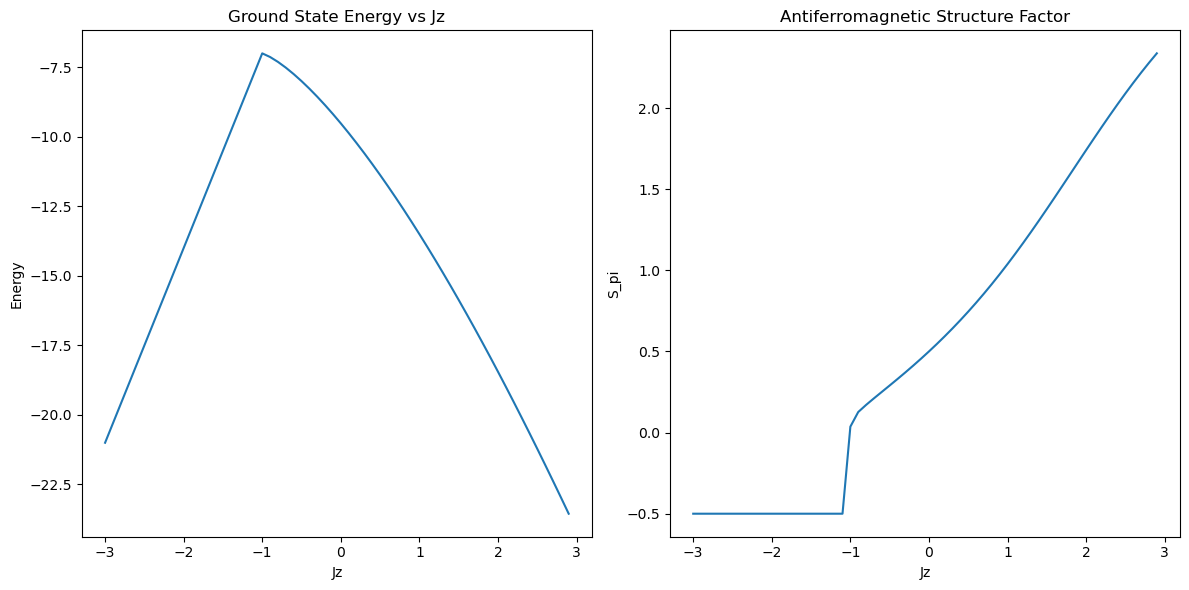

In [69]:
def s_pi_operator(n):
    terms = []

    for i in range(n):
        for j in range(i+1, n):
            pauli = ["I"] * n
            pauli[i] = "Z"
            pauli[j] = "Z"
            coeff = ((-1) ** (i - j)) / n
            terms.append(("".join(pauli), coeff))

    return SparsePauliOp.from_list(terms)

numpy_solver = NumPyEigensolver(k=2)

J = []
E0 = []
Spi = []

s_pi_op_mat = np.array(s_pi_operator(n).to_matrix())

for j in np.arange(-3, 3, 0.1):
    h = heisenberg_hamiltonian(n, Jz = j)
    h_mat = np.array(h.to_matrix())

    eigenvalues, eigenvectors = eigh(h_mat)
    e0 = eigenvalues[0]
    psi0 = eigenvectors[:, 0]
    s_pi = np.real(psi0.conj() @ s_pi_op_mat @ psi0)
    
    J.append(j)
    E0.append(e0)
    Spi.append(s_pi)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(J, E0, label='Ground State Energy')
plt.xlabel('Jz')
plt.ylabel('Energy')
plt.title('Ground State Energy vs Jz')

plt.subplot(1, 2, 2)
plt.plot(J, Spi, label='S_pi Expectation Value')
plt.xlabel('Jz')
plt.ylabel('S_pi')
plt.title('Antiferromagnetic Structure Factor')
plt.tight_layout()
plt.show()

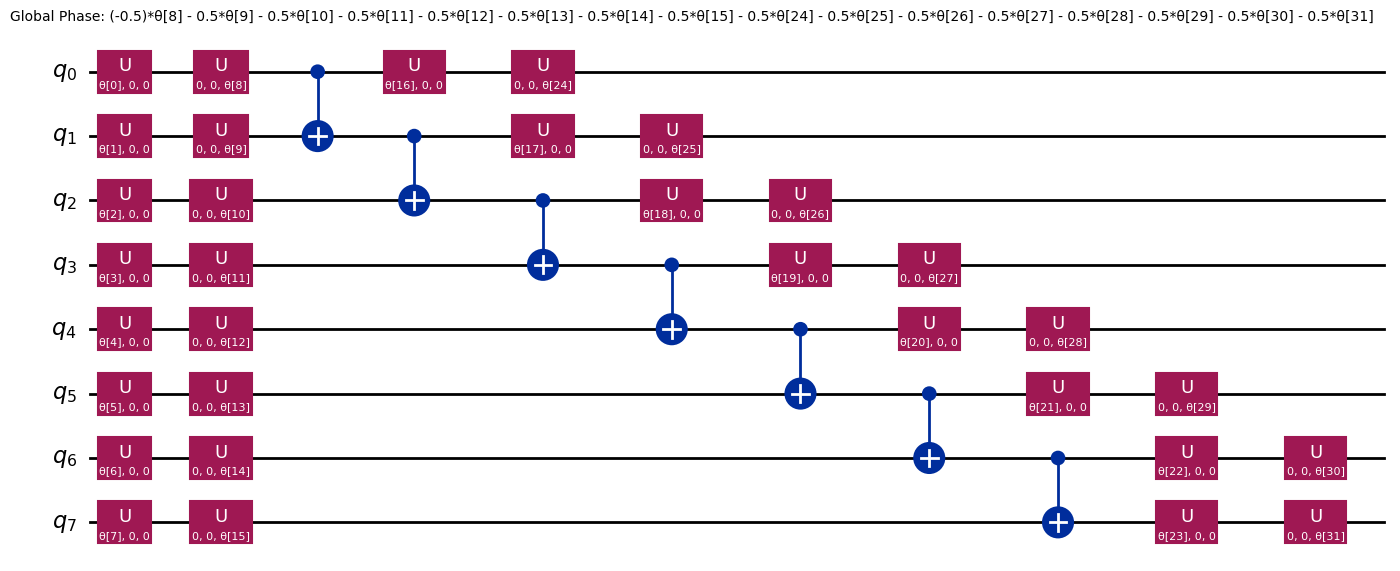

In [70]:
iterations = 300
ansatz = efficient_su2(n, entanglement = 'linear', reps = 1).decompose()
spsa = SPSA(maxiter=iterations)
ansatz.decompose().draw('mpl')

In [71]:
counts = []
values = []
counts_noisy = []
values_noisy = []

def store_noiseless_intermediate_result(eval_count, paramters, mean, std):
    counts.append(eval_count)
    values.append(mean)

def store_noisy_intermediate_result(eval_count, paramters, mean, std):
    counts_noisy.append(eval_count)
    values_noisy.append(mean)
    

In [72]:
estimator = StatevectorEstimator()

seed = 64
algorithm_globals.random_seed = seed

noiseless_estimator = StatevectorEstimator()

In [73]:
coupling_map = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7]]


# Use a real noise model after making IBM Quantum account
# service = QiskitRuntimeService()
# real_backend = service.backend("ibm_heron")
# noise_model = NoiseModel.from_backend(real_backend)
# aer_sim = AerEstimator(noise_model=noise_model, coupling_map=coupling_map)

device = GenericBackendV2(num_qubits = n, coupling_map = coupling_map, seed = seed)

noise_model = NoiseModel.from_backend(device)

noisy_estimator = AerEstimator(
    options = {
        "default_precision": 1e-2,
        "backend_options": {
            "method": "density_matrix",
            "coupling_map": coupling_map,
            "noise_model": noise_model
        }
    }
)

In [74]:
vqe_noiseless = VQE(noiseless_estimator, ansatz, spsa, callback = store_noiseless_intermediate_result)
results_noiseless = vqe_noiseless.compute_minimum_eigenvalue(H)

vqe_noisy = VQE(noisy_estimator, ansatz, spsa, callback = store_noisy_intermediate_result)
results_noisy = vqe_noisy.compute_minimum_eigenvalue(H)

print(f"Noiseless VQE result: {results_noiseless.eigenvalue.real}")
print(f"Delta from reference: {results_noiseless.eigenvalue.real - ref_val}")
print(f"Noisy VQE result: {results_noisy.eigenvalue.real}")
print(f"Delta from reference: {results_noisy.eigenvalue.real - ref_val}")

Noiseless VQE result: -21.960622343335302
Delta from reference: 2.188060340587306
Noisy VQE result: -21.889072050304552
Delta from reference: 2.259610633618056


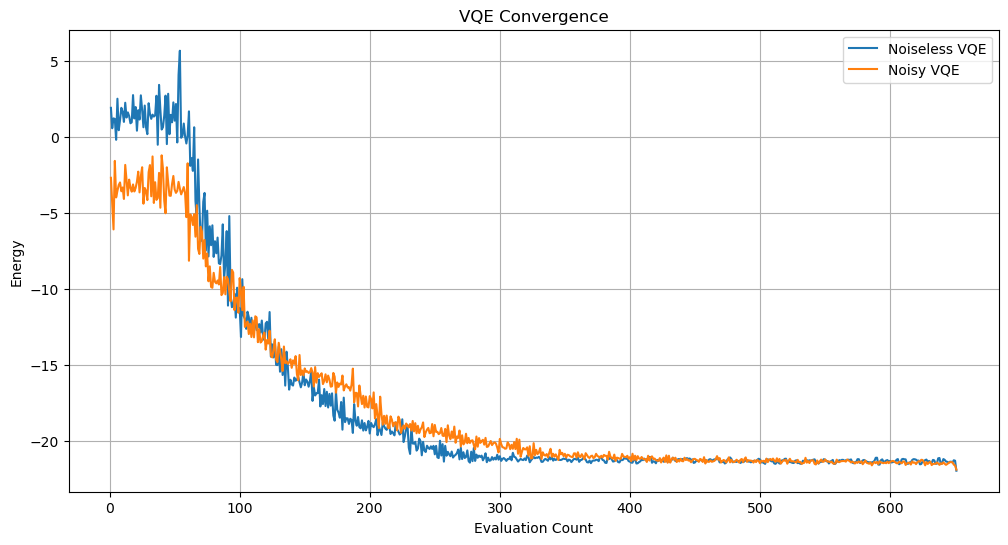

In [75]:
plt.figure(figsize=(12, 6))
plt.plot(counts, values, label='Noiseless VQE')
plt.plot(counts_noisy, values_noisy, label='Noisy VQE')
plt.xlabel('Evaluation Count')
plt.ylabel('Energy')
plt.title('VQE Convergence')
plt.grid()
plt.legend()
plt.show()

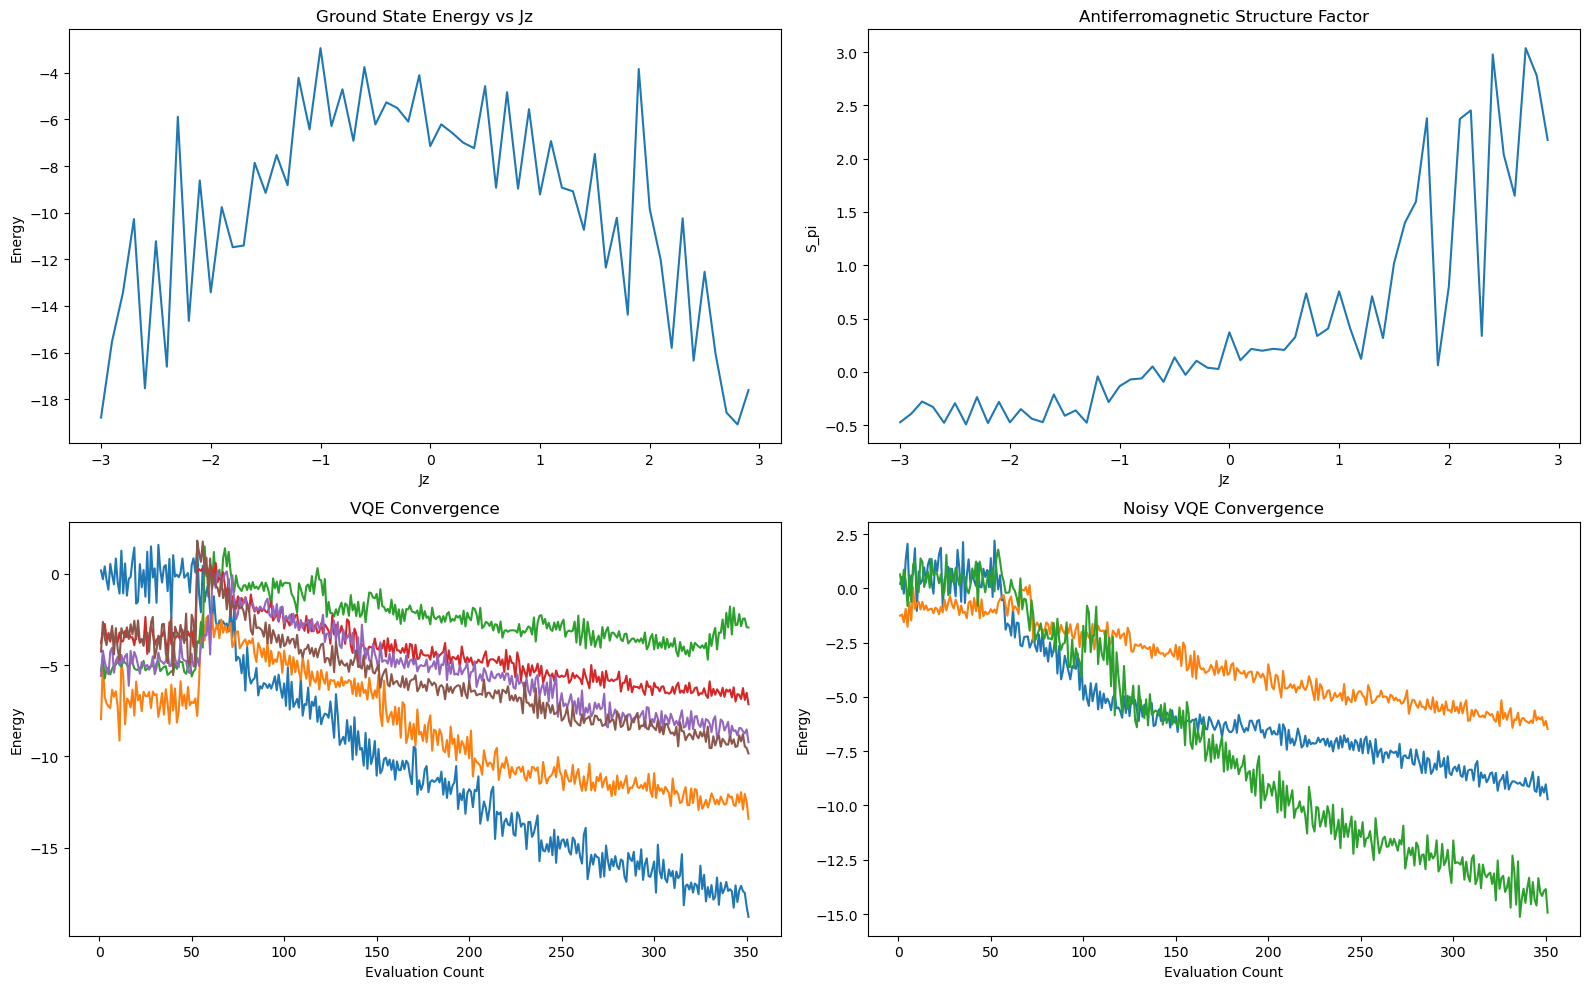

In [87]:
counts.clear(); values.clear()
counts_noisy.clear(); values_noisy.clear()

all_counts = []
all_values = []

def store_noiseless_intermediate_result(eval_count, paramters, mean, std):
    if eval_count == 1:
        all_counts.append([])
        all_values.append([])
    all_counts[-1].append(eval_count)
    all_values[-1].append(mean)
    counts.append(eval_count)
    values.append(mean)

all_counts_noisy = []
all_values_noisy = []

def store_noisy_intermediate_result(eval_count, paramters, mean, std):
    if eval_count == 1:
        all_counts_noisy.append([])
        all_values_noisy.append([])
    all_counts_noisy[-1].append(eval_count)
    all_values_noisy[-1].append(mean)
    counts_noisy.append(eval_count)
    values_noisy.append(mean)


optimizer = SPSA(maxiter=150)
ansatz = efficient_su2(n, entanglement = 'linear', reps = 2).decompose()

vqe_noiseless = VQE(noiseless_estimator, ansatz, optimizer, callback = store_noiseless_intermediate_result)
vqe_noisy = VQE(noisy_estimator, ansatz, optimizer, callback = store_noisy_intermediate_result)

J, E0, Spi = [], [], []

opt_params = None

for j in np.arange(-3, 3, 0.1):
    H = heisenberg_hamiltonian(n, Jz = j)
    
    if opt_params is not None:
        vqe_noiseless.initial_point = opt_params
    
    results = vqe_noiseless.compute_minimum_eigenvalue(H)
    opt_params = results.optimal_point

    prim = noiseless_estimator.run(
        [(ansatz, s_pi_operator(n), opt_params)]
    ).result()


    J.append(j)
    E0.append(float(np.real(results.eigenvalue)))
    Spi.append(float(np.real(prim[0].data.evs)))

noisy_spot_j = [-2, 0, 2]
noisy_spot_e = []

for j in noisy_spot_j:
    H = heisenberg_hamiltonian(n, Jz = j)
    results_noisy = vqe_noisy.compute_minimum_eigenvalue(H)
    noisy_spot_e.append(float(np.real(results_noisy.eigenvalue)))


plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(J, E0, label='Ground State Energy')
plt.xlabel('Jz')
plt.ylabel('Energy')
plt.title('Ground State Energy vs Jz')

plt.subplot(2, 2, 2)
plt.plot(J, Spi, label='S_pi Expectation Value')
plt.xlabel('Jz')
plt.ylabel('S_pi')
plt.title('Antiferromagnetic Structure Factor')

plt.subplot(2, 2, 3)
for i in range(0, len(all_counts), 10):
        plt.plot(all_counts[i], all_values[i])
plt.xlabel('Evaluation Count')
plt.ylabel('Energy')
plt.title('VQE Convergence')

plt.subplot(2, 2, 4)
for i in range(0, len(all_counts_noisy)):
    plt.plot(all_counts_noisy[i], all_values_noisy[i])
plt.xlabel('Evaluation Count')
plt.ylabel('Energy')
plt.title('Noisy VQE Convergence')

plt.tight_layout()
plt.show()